In [3]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 907 kB 4.0 MB/s 


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.0 MB/s 
     |████████████████████████████████| 9.9 MB 27.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import statsmodels.api as sm
from scipy import stats

sns.set(rc={'figure.figsize':(15, 7)})
plt.rcParams['figure.figsize'] = (15, 7)
warnings.filterwarnings('ignore')

In [5]:
# Загружаем данные
data = pd.read_csv('/datasets/monthly-milk-production.csv', sep=';', index_col='month', squeeze=True)
data

month
01.01.1962    589
01.02.1962    561
01.03.1962    640
01.04.1962    656
01.05.1962    727
             ... 
01.08.1975    858
01.09.1975    817
01.10.1975    827
01.11.1975    797
01.12.1975    843
Name: milk, Length: 168, dtype: int64

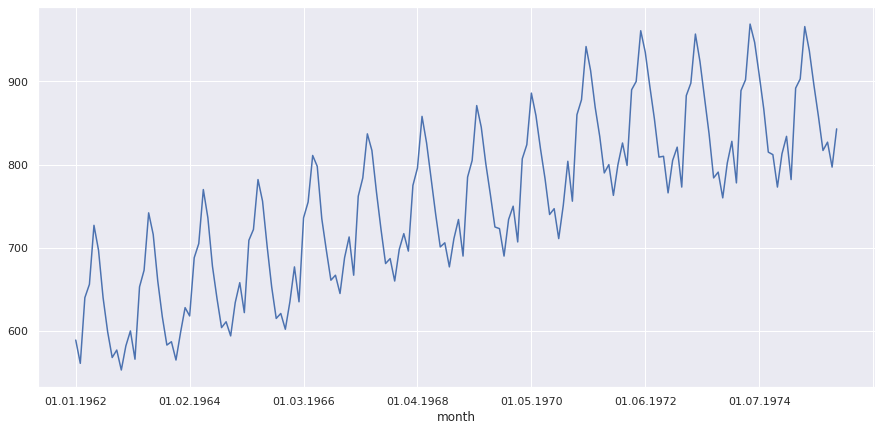

In [6]:
# Визуализируем данные
data.plot()
plt.show()

* Видна сезонность, виден тренд. Используем аддитивную модель для декомпозиции ряда, периодичность - 12 месяцев. Также используем процедуру Бокса-Кокса для сглаживания данных.

In [7]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

data_box, lmbda = stats.boxcox(data)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.838297


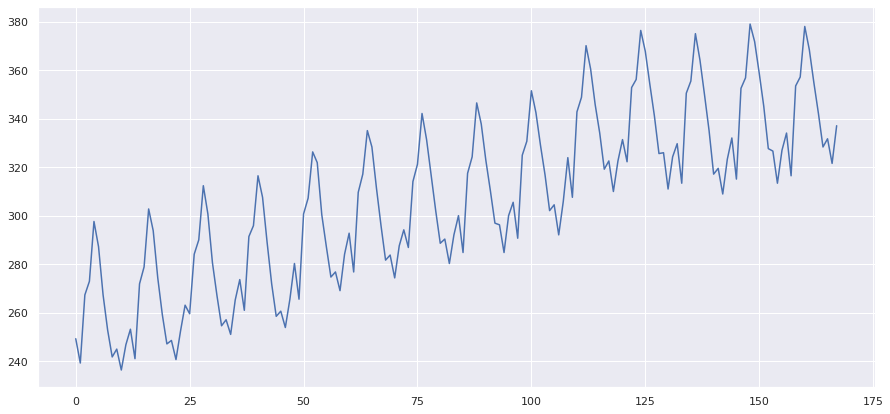

In [9]:
# Визуализируем сглаженный ряд
plt.plot(data_box)
plt.show()

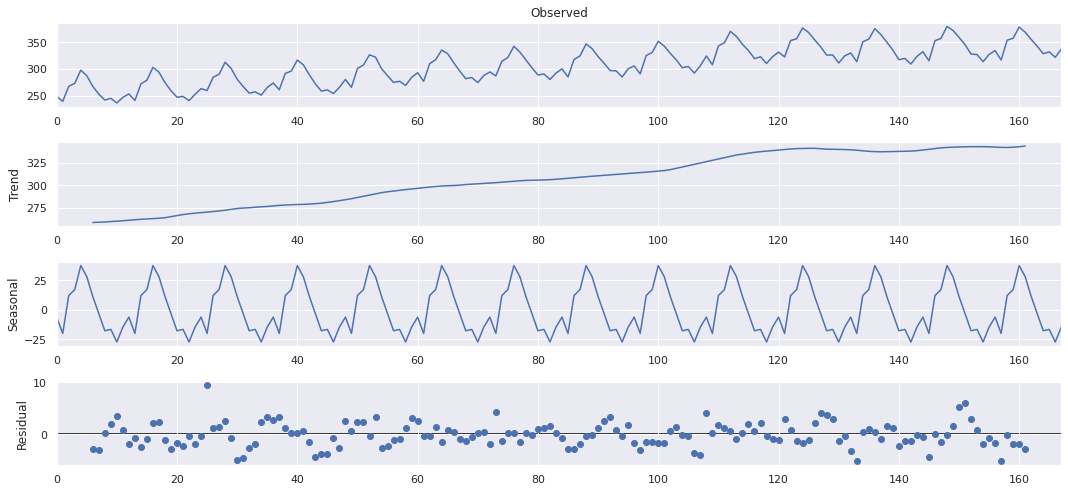

In [10]:
sm.tsa.seasonal_decompose(data_box, period=12).plot()
plt.show()

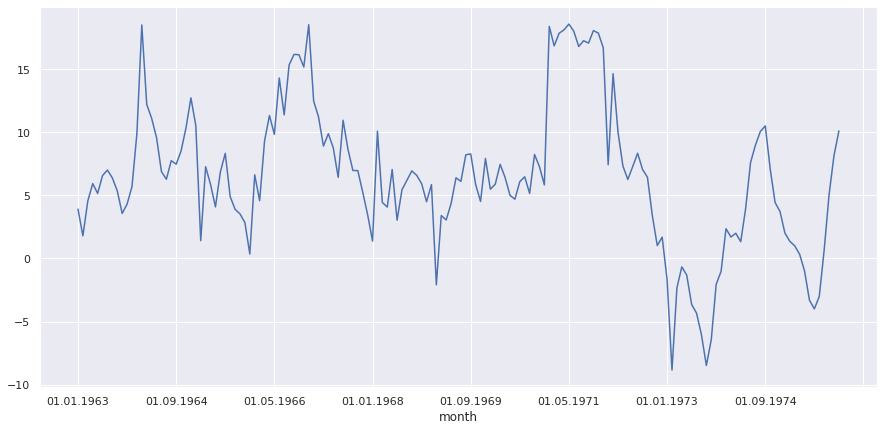

In [11]:
data_diff_seasonal = pd.Series(data_box, index=data.index).diff(12).dropna()

data_diff_seasonal.plot()
plt.show()

* От сезонности удалось избавиться, теперь нужно выровнять ряд в стационарный вид.

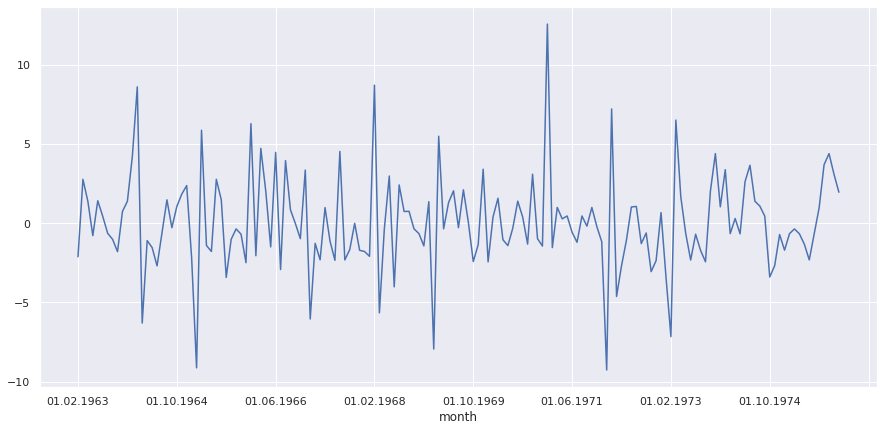

In [12]:
data_diff = data_diff_seasonal.diff().dropna()

data_diff.plot()
plt.show()

* Ряд похож на стационарный, пусть и не до конца. Проверим остатки через декомпозицию.

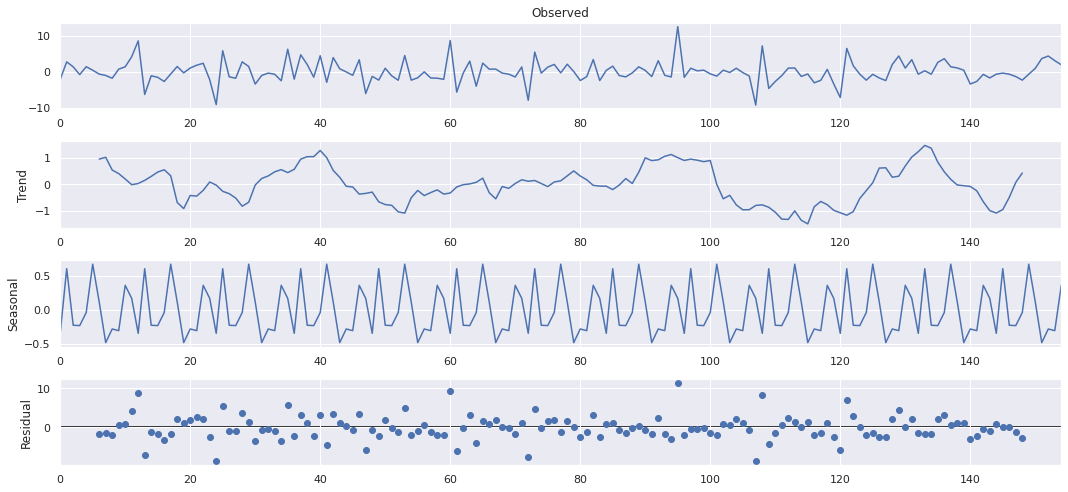

In [13]:
sm.tsa.seasonal_decompose(np.array(data_diff), period=12).plot()
plt.show()

In [14]:
# Проверим стационарность через тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

print('Ряд', str('стационарен.' if adfuller(data_diff)[1] < 0.05 else 'нестационарен.'))

Ряд стационарен.


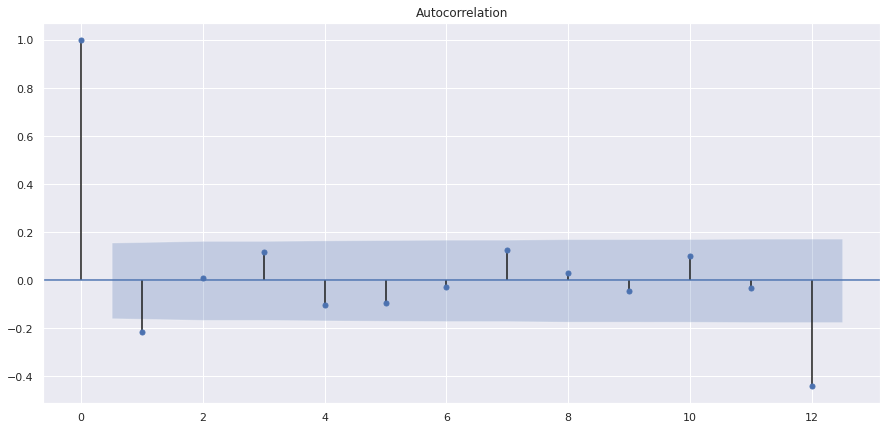

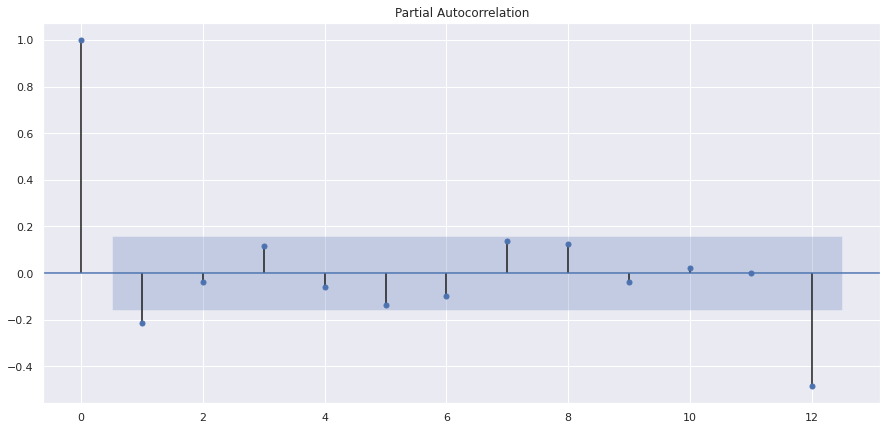

In [15]:
# Подберем параметры p и q
sm.graphics.tsa.plot_acf(data_diff, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(data_diff, lags=12)
plt.show()

* Параметры p и q подобрать сложно, пока возьмем ARMA(1,1).

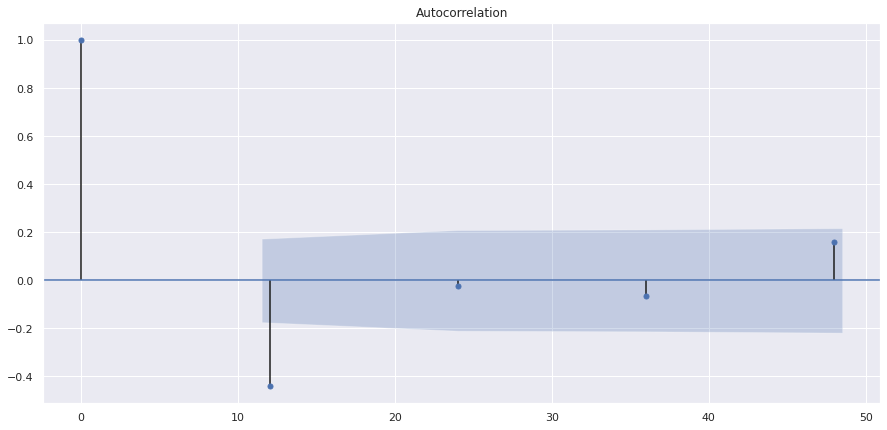

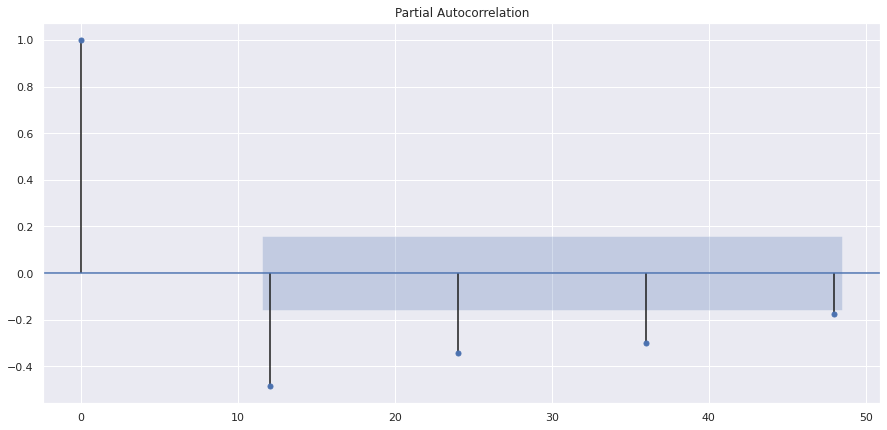

In [16]:
# Подберем параметры P и Q
sm.graphics.tsa.plot_acf(data_diff, lags=[0,12,24,36,48])
plt.show()
sm.graphics.tsa.plot_pacf(data_diff, lags=[0,12,24,36,48])
plt.show()

* Для сезонной компоненты отлично виден процесс MA(1).

In [17]:
model=sm.tsa.statespace.SARIMAX(data_box, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -364.153
Date:                            Sat, 10 Dec 2022   AIC                            736.307
Time:                                    15:04:31   BIC                            748.481
Sample:                                         0   HQIC                           741.251
                                            - 168                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0949      0.355     -0.268      0.789      -0.790       0.601
ma.L1         -0.1280      0.352     -0.364      0.716      -0.817       0.561
ma.S.L12      -0.6376      0.071     -8.982      0.000      -0.777      -0.498
sigma2         6.1729      0.605     10.208      0.000       4.988       7.358
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                30.59
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.72
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* ARMA компоненты статистически незначимы. Проверим лучшую модель через auto_arima.

In [18]:
from pmdarima import auto_arima

best_model = auto_arima(data_box, start_p=0, start_q=0, max_p=3, max_q=3, d=1, D=1, m=12, out_of_sample_size=36)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -364.204
Date:                            Sat, 10 Dec 2022   AIC                            734.407
Time:                                    15:04:48   BIC                            743.537
Sample:                                         0   HQIC                           738.116
                                            - 168                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2163      0.075     -2.875      0.004      -0.364      -0.069
ma.S.L12      -0.6389      0.071     -9.009      0.000      -0.778      -0.500
sigma2         6.1756      0.607     10.179      0.000       4.987       7.365
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                30.11
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.72
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Сезонную компоненту удалось определить верно, но ARMA(1,1) процесс следует заменить на MA(1). 

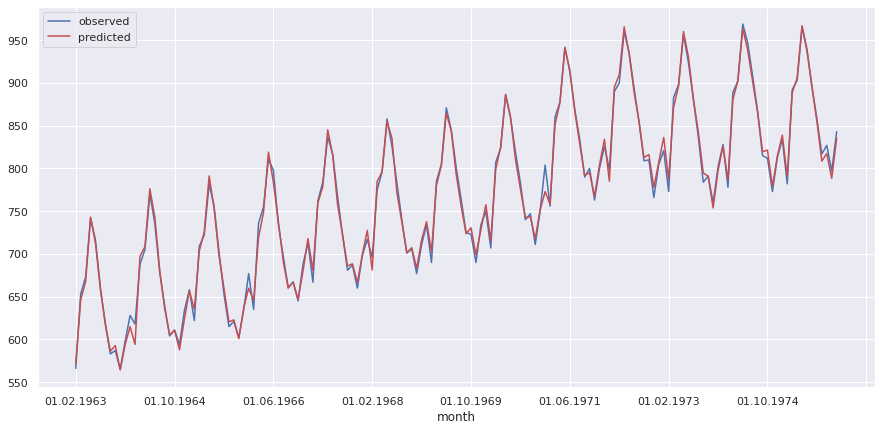

In [20]:
data[13:].plot(label='observed')
pd.Series(invboxcox(best_model.fittedvalues(), lmbda), index=data.index)[13:].plot(color='r', label='predicted')
plt.legend()
plt.show()

In [21]:
# Посчитаем метрику R-квадрат
from sklearn.metrics import r2_score

print(f'Коэффициент детерминации: {r2_score(data[13:], invboxcox(best_model.fittedvalues(), lmbda)[13:])}')

Коэффициент детерминации: 0.9941439976710585


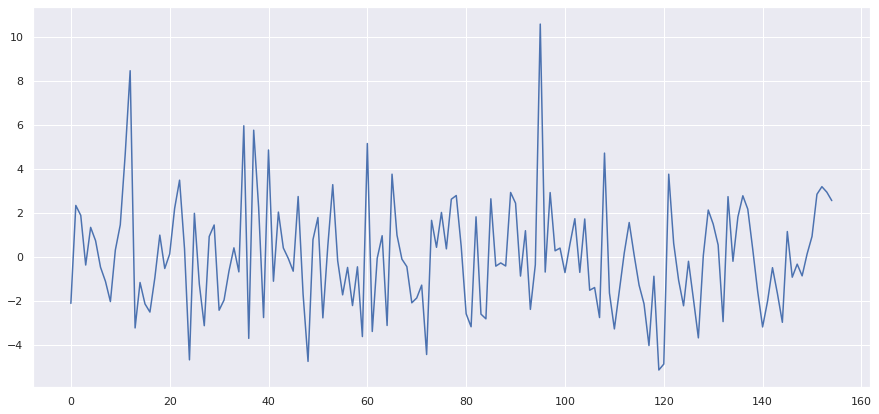

In [22]:
# Посмотрим на поведение остатков
plt.plot(best_model.resid()[13:])
plt.show()

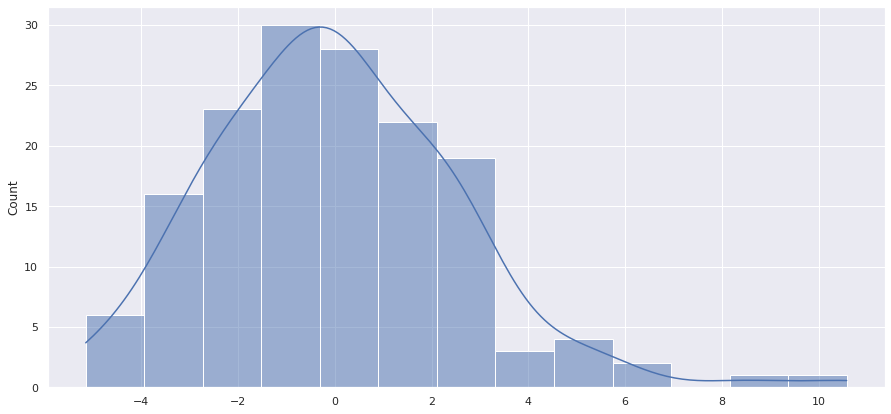

In [23]:
sns.histplot(best_model.resid()[13:], kde=True)
plt.show()

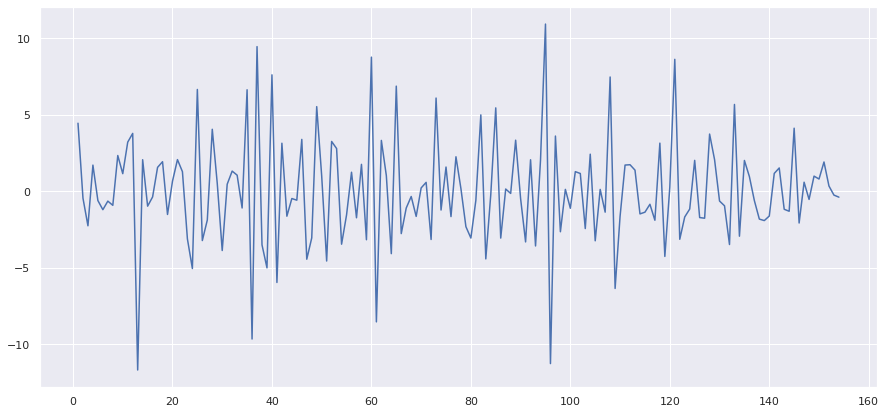

In [24]:
plt.plot(pd.Series(best_model.resid()[13:]).diff().dropna())
plt.show()

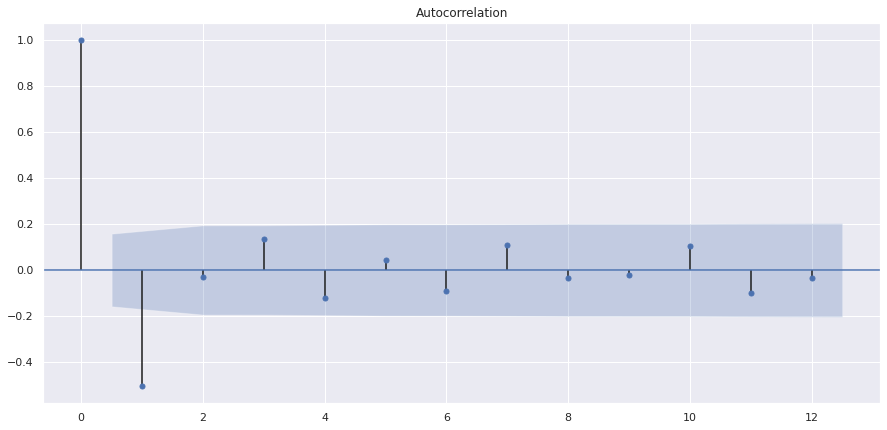

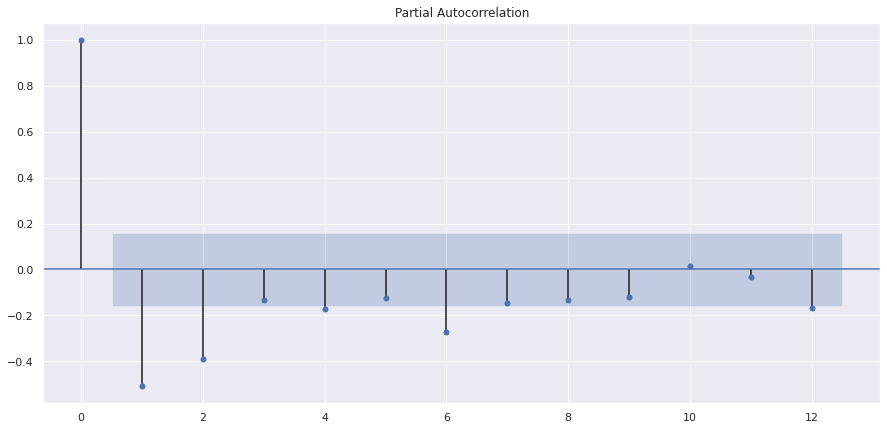

In [49]:
# Подберем параметры p и q для GARCH-модели
sm.graphics.tsa.plot_acf(pd.Series(best_model.resid()[13:]).diff().dropna(), lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(pd.Series(best_model.resid()[13:]).diff().dropna(), lags=12)
plt.show()

In [51]:
from arch import arch_model

best_aic = np.inf
best_p = 0
best_q = 0

resid = pd.Series(best_model.resid()[13:]).diff().dropna()

for p in range(1,5):
  for q in range(1,5):
    model = arch_model(resid, p=p, q=q, mean='Zero').fit()
    if model.aic < best_aic:
      best_aic = model.aic
      best_p = p
      best_q = q

print(f'Best p: {best_p}')
print(f'Best q: {best_q}')

Iteration:      1,   Func. Count:      5,   Neg. LLF: 406.1103059515931
Iteration:      2,   Func. Count:     10,   Neg. LLF: 410.4204943966937
Iteration:      3,   Func. Count:     15,   Neg. LLF: 403.4392900696369
Iteration:      4,   Func. Count:     20,   Neg. LLF: 433.1703581098178
Iteration:      5,   Func. Count:     25,   Neg. LLF: 403.13678134015197
Iteration:      6,   Func. Count:     29,   Neg. LLF: 403.12603006184816
Iteration:      7,   Func. Count:     33,   Neg. LLF: 403.1243466007486
Iteration:      8,   Func. Count:     37,   Neg. LLF: 403.1242518420285
Iteration:      9,   Func. Count:     41,   Neg. LLF: 403.12424825567507
Iteration:     10,   Func. Count:     44,   Neg. LLF: 403.1242482557853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 403.12424825567507
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      6,   Neg. LLF: 406.070556922

In [52]:
best_garch = arch_model(resid, p=best_p, q=best_q, mean='Zero').fit()
best_garch.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 406.1103059515931
Iteration:      2,   Func. Count:     10,   Neg. LLF: 410.4204943966937
Iteration:      3,   Func. Count:     15,   Neg. LLF: 403.4392900696369
Iteration:      4,   Func. Count:     20,   Neg. LLF: 433.1703581098178
Iteration:      5,   Func. Count:     25,   Neg. LLF: 403.13678134015197
Iteration:      6,   Func. Count:     29,   Neg. LLF: 403.12603006184816
Iteration:      7,   Func. Count:     33,   Neg. LLF: 403.1243466007486
Iteration:      8,   Func. Count:     37,   Neg. LLF: 403.1242518420285
Iteration:      9,   Func. Count:     41,   Neg. LLF: 403.12424825567507
Iteration:     10,   Func. Count:     44,   Neg. LLF: 403.1242482557853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 403.12424825567507
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -403.124
Distribution:                  Normal   AIC:                           812.248
Method:            Maximum Likelihood   BIC:                           821.359
                                        No. Observations:                  154
Date:                Sat, Dec 10 2022   Df Residuals:                      154
Time:                        15:37:14   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          7.1440      4.891      1.461      0.144   [ -2.442, 16.730]
alpha[1]       0.4702      0.193      2.440  1.470e-02 [9.245e-02,  0.848]
beta[1]        0.0000      0.356      0.000      1.000   [ -0.697,  0.697]
==========================================================================

Covariance estimator: robust
"""

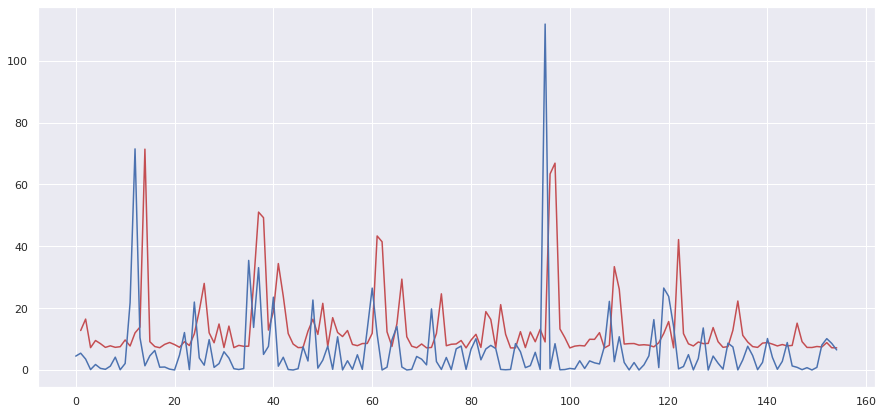

In [55]:
(best_garch.conditional_volatility**2).plot(color='r')
plt.plot((best_model.resid()[13:]**2))
plt.show()